In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json

In [2]:
from sklearn.preprocessing import StandardScaler

In [31]:
import torch

In [16]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

In [3]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [6]:
!pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.6 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.6 kB 393.8 kB/s eta 0:00:01
   --------------- ---------------------- 122.9/294.6 kB 901.1 kB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 1.8 MB/s eta 0:00:00


In [7]:
import seaborn as sns

In [12]:
from scipy import stats

In [8]:
import matplotlib.pyplot as plt

In [9]:
data = pd.read_csv('../data/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.0.2/features_v2.csv')

In [10]:
feature_cols = [c for c in data.columns if "_" in c]

In [13]:
new_data = data[(np.abs(stats.zscore(data.loc[:, feature_cols])) < 4).all(axis = 1)].reset_index()

In [14]:
feature_cols = [c for c in new_data.columns if "_" in c]

In [44]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 128)
        self.l2 = nn.Linear(128, embed_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l2(x)
        return x

class ClassificationHead(nn.Module):
    def __init__(self,embed_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(embed_dim, 64)
        self.l2 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l2(x)
        return x

class UserClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, embed_dim)
        self.decoder = ClassificationHead(embed_dim, output_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [70]:
X = new_data.loc[:, feature_cols].values
Y = (new_data.loc[:, 'participant']-1).values
g = (new_data.loc[:, 'gesture']-1).values

In [71]:
g

array([9, 9, 9, ..., 8, 8, 8], dtype=int64)

In [25]:
from pickle import load

In [27]:
scaler  = load(open('scaler.pkl', 'rb'))
# scaler

In [28]:
X = scaler.transform(X)

In [29]:
X

array([[ 1.11765882,  0.60631332,  0.31658555, ...,  0.05897757,
        -0.18440799,  0.44383681],
       [ 1.93515067, -0.01995706, -0.20100956, ..., -0.167033  ,
        -0.45467839,  0.30966458],
       [ 2.28680368,  1.13416332,  0.79485252, ...,  0.30521437,
         0.11636799, -0.56245494],
       ...,
       [ 0.11978767,  0.23851329, -0.04896466, ..., -0.21304864,
        -0.4094909 , -0.56245494],
       [ 0.58391268, -0.07164632, -0.26491991, ..., -0.288517  ,
        -0.94294237, -0.56245494],
       [ 0.4683518 , -0.00296727, -0.21351676, ..., -0.26477394,
        -0.84061351, -0.29411047]])

In [20]:
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2023)

In [21]:
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test) 

In [45]:
encoder = Encoder(x_train.shape[1], 128)

In [46]:
X

array([[ 1.11765882,  0.60631332,  0.31658555, ...,  0.05897757,
        -0.18440799,  0.44383681],
       [ 1.93515067, -0.01995706, -0.20100956, ..., -0.167033  ,
        -0.45467839,  0.30966458],
       [ 2.28680368,  1.13416332,  0.79485252, ...,  0.30521437,
         0.11636799, -0.56245494],
       ...,
       [ 0.11978767,  0.23851329, -0.04896466, ..., -0.21304864,
        -0.4094909 , -0.56245494],
       [ 0.58391268, -0.07164632, -0.26491991, ..., -0.288517  ,
        -0.94294237, -0.56245494],
       [ 0.4683518 , -0.00296727, -0.21351676, ..., -0.26477394,
        -0.84061351, -0.29411047]])

In [47]:
dataset = TensorDataset(torch.tensor(X).type(torch.float32), torch.tensor(Y).type(torch.LongTensor))

In [54]:
# Define batch size and whether to shuffle the data
batch_size = 256

# Create data loaders for training and testing
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [50]:
encoder

Encoder(
  (l1): Linear(in_features=756, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
)

In [51]:
encoder.load_state_dict(torch.load('encoder.pth'), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['relu.x', 'relu.y'])

In [58]:
def embed(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            # _, predicted = torch.max(outputs, 1)
            y_pred.extend(outputs)

    return torch.stack(y_pred)

In [61]:
embeddings = embed(model=encoder, test_loader=loader)

In [63]:
embeddings.shape

torch.Size([11004, 128])

In [65]:
Y.shape

(11004,)

In [66]:
tsne = TSNE()
tsne_features = tsne.fit_transform(embeddings)

In [67]:
participants = Y

## Gesture 2

In [78]:
sub_parts = np.random.choice(participants, size = 15, replace=False)

In [86]:
i = np.where(g == 2)
feats = np.squeeze(tsne_features[i,:])
labels = participants[i]

In [87]:
feats.shape

(755, 2)

In [91]:
labels

array([ 0,  0,  0,  0,  0,  0,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 17, 17,
       18, 18, 18, 18, 18, 18, 18,  1,  1,  1,  1,  1,  1, 19, 19, 19, 19,
       20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22,
       22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25,
       25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27,
       28, 28, 28, 28, 28, 28, 28,  2,  2,  2,  2,  2,  2, 29, 29, 29, 29,
       29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31,
       32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34,
       34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 37,
       37, 37, 37, 38, 38, 38, 38, 38, 38,  3,  3,  3,  3,  3,  3,  3, 39,
       39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 42,
       42, 42,  4,  4,  4

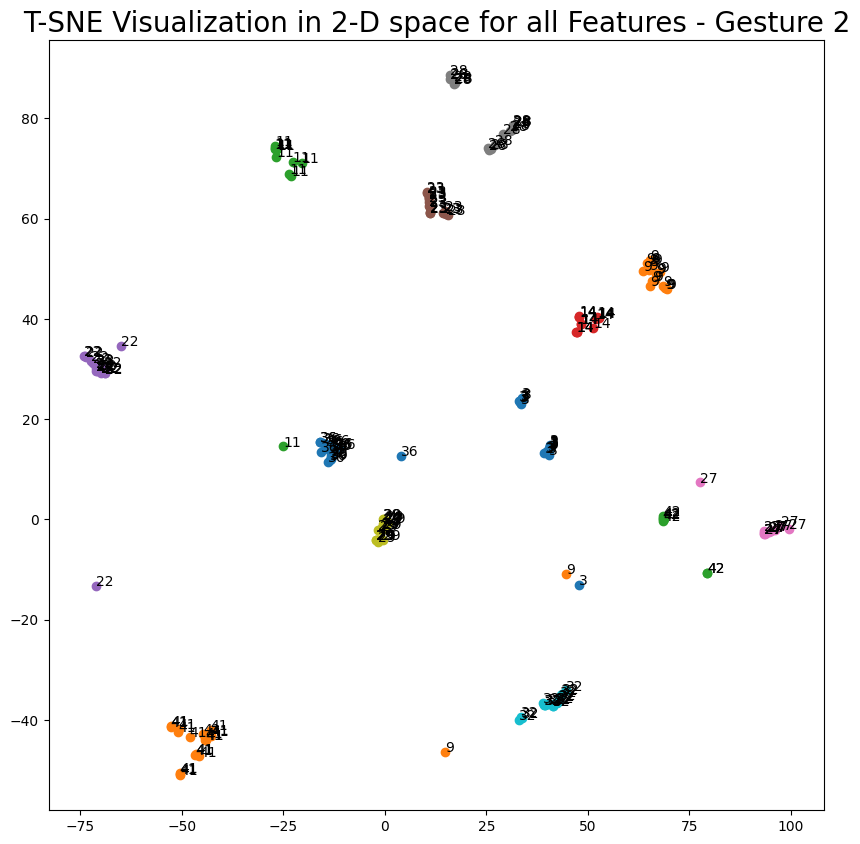

In [90]:
fig, ax = plt.subplots(figsize= (10,10))

# ax.scatter(x = tsne_features[:,0], y = tsne_features[:,1], label = participants)
for p in np.unique(sub_parts):
    i = np.where(labels == p)
    ax.scatter(feats[i,0], feats[i,1], label=p)
#     ax.annotate(p, (tsne_features[i,0], tsne_features[i,1]))
# ax.legend()
for idx, label in enumerate(labels):
    if label in sub_parts:
        ax.annotate(label, (feats[idx,0], feats[idx,1]))
    
ax.set_title("T-SNE Visualization in 2-D space for all Features - Gesture 2", fontsize= 20)
plt.show()